# Analytical solution

In this notebook, we will compare our finite difference solution of the 3D homogeneous viscoelastic infinite space wave equation with the analytical solution to measure the robustness of our method.

## Theory

The analytical solution to the 3D isotropic viscoelastic wave equation in an homogenous and infite medium as been known for some time [Aki & Richards, 2002](https://ui.adsabs.harvard.edu/abs/2002quse.book.....A). By following [Gosselin-Cliche & Giroux (2014)](https://doi.org/10.1190/geo2013-0368.1) we can have an explicite function of this solution for a force in z :

<br>

$$\begin{aligned}
u_{x}=\frac{f(\omega)}{4 \pi \rho|x|^{5} \omega^{2}} &\left[x z\left(|x|^{2} k_{p}^{2}-3-3 i|x| k_{p}\right) e^{-i k_{p}|x|}-\left(|x|^{2} k_{s}^{2}-3-3 i|x| k_{s}\right) e^{-i k_{s}|x|}\right] \\
u_{y}=\frac{f(\omega)}{4 \pi \rho|x|^{5} \omega^{2}} &\left[y z\left(|x|^{2} k_{p}^{2}-3-3 i|x| k_{p}\right) e^{-i k_{p}|x|}-\left(|x|^{2} k_{s}^{2}-3-3 i|x| k_{s}\right) e^{-i k_{s}|x|}\right] \\
u_{z}=\frac{f(\omega)}{4 \pi \rho|x|^{5} \omega^{2}} &\left[\left(x^{2}+y^{2}-2 z^{2}\right)\left(e^{-i k_{p}|x|}-e^{-i k_{s}|x|}\right) \ \right. +\left(z^{2}|x|^{2} k_{p}^{2}+i\left(x^{2}+y^{2}-2 z^{2}\right)|x| k_{p}\right) e^{-i k_{p}|x|} \\
&\left.+\left(\left(x^{2}+y^{2}\right)|x|^{2} k_{s}^{2}-i\left(x^{2}+y^{2}-2 z^{2}\right)|x| k_{s}\right) e^{-i k_{s}|x|}\right]
\end{aligned}$$



<br>

where $ k_p = \omega \sqrt{\frac{\rho}{M}} $ and $ \normalsize k_p = \omega \sqrt{\frac{\rho}{\mu}} $.



## Finite difference solution

Let's start by solving with SeisCL the viscoelastic wave equation in a simple homogeneous medium.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seis = SeisCL()

In [2]:
seis.csts['ND'] = 3
seis.csts['N'] = np.array([250, 250, 250])
seis.csts['dt'] = dt = 0.25e-03
seis.csts['dh'] = dh = 2
seis.csts['NT'] = NT = 1500
seis.csts['FDORDER'] = 4

nbuf = seis.csts['FDORDER'] * 2
nab = seis.csts['nab']
N = seis.csts['N'][0]

seis.csts['L'] = 1
seis.csts['FL'] = np.array([seis.csts["f0"]])

vp = 3500
vs = 2000
rho = 2000
taup = 0.2
taus = 0.2

vp_a = np.zeros(seis.csts['N']) + vp
vs_a = np.zeros(seis.csts['N']) + vs
rho_a = np.zeros(seis.csts['N']) + rho
taup_a = np.zeros(seis.csts['N']) + taup
taus_a = np.zeros(seis.csts['N']) + taus

model_dict = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a, "taus": taus_a}

In [3]:
sx = (nab + nbuf) * dh
sy = N // 2 * dh
sz = N // 2 * dh
offmin = 5 * dh
offmax = (N - nab - nbuf) * dh - sx
gx = np.arange(sx + offmin, sx + offmax, dh)
gy = gx * 0 + N // 2 * dh
gz = gx * 0 + N // 2 * dh
offset = gx-sx

seis.src_pos_all = np.stack([[sx], [sy], [sz], [0], [2]], axis=0)

gsid = gz * 0
gid = np.arange(0, len(gz))
seis.rec_pos = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)
seis.rec_pos_all = seis.rec_pos

In [4]:
seis.csts['seisout'] = 1
seis.set_forward(gsid, model_dict, withgrad=False)
seis.execute()
datafd = seis.read_data()

Now for the analytical solution, we will use an internal function of SeisCL <code>viscoelastic_3D</code>. 


It will need all the parameters of the model, the frequency of operations, the frequency of attenuation, the timesteps, the positions of the receivers with respect to the sources and finally the waveform of the source.

Note that the waveform of the source given is twice the frequency of the source use in the finite difference simulation because...

In [5]:
from SeisCL import viscoelastic_3D

src = seis.ricker_wavelet(NT = 2*NT)

for ii in range(0, len(gx)):
    rec_test = [gx[ii]-sx, gy[ii]-sy, gz[ii]-sz]
    
rec_pos = [[gx[ii]-sx, gy[ii]-sy, gz[ii]-sz] for ii in range(0, len(gx))]


analytic = viscoelastic_3D(vp, vs, rho, taup, taus,
                            seis.csts['f0'], seis.csts['FL'],
                            seis.csts['dt'], rec_pos, src)

analytic = analytic[-1][:NT, :]

We can now compare the results, but first we'll normalize the two with respect to their respective maximum.

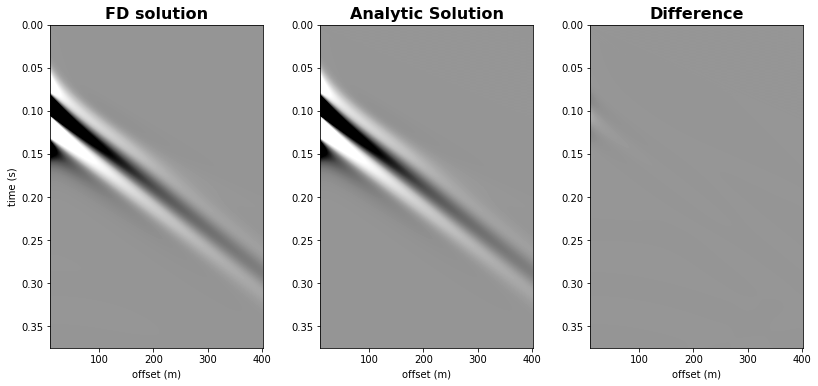

In [6]:
datafd = datafd / np.max(datafd)
analytic = analytic / np.max(analytic)

# datafd = datafd / np.sqrt(np.sum(datafd ** 2))
# analytic = analytic / np.sqrt(np.sum(analytic ** 2))

err = np.sqrt(np.sum( (datafd - analytic)**2) / np.sum(analytic**2))


#Plot with shot fd, shot ana, diff
clip = 0.1
vmax = np.max(datafd) * clip
vmin = -vmax
extent=[np.min(offset), np.max(offset), (datafd.shape[0]-1)*dt, 0]

fig, ax = plt.subplots(1, 3, figsize=[12, 6])

ax[0].imshow(datafd, aspect='auto', vmax=vmax, vmin=vmin,
                extent=extent, interpolation='bilinear',
                cmap=plt.get_cmap('Greys'))
ax[0].set_title("FD solution", fontsize=16, fontweight='bold')
ax[0].set_xlabel("offset (m)")
ax[0].set_ylabel("time (s)")
ax[1].imshow(analytic, aspect='auto', vmax=vmax, vmin=vmin,
                extent=extent, interpolation='bilinear',
                cmap=plt.get_cmap('Greys'))
ax[1].set_title("Analytic Solution", fontsize=16, fontweight='bold')
ax[1].set_xlabel("offset (m)")
ax[2].imshow(datafd - analytic, aspect='auto', vmax=vmax, vmin=vmin,
                extent=extent, interpolation='bilinear',
                cmap=plt.get_cmap('Greys'))
ax[2].set_title("Difference", fontsize=16, fontweight='bold')
ax[2].set_xlabel("offset (m)")
plt.tight_layout(h_pad=2, w_pad=2, pad=3)
plt.show()

As we can see, the finite difference solution is quite close to the analytical one. 


<!-- Futhermore, we can find the offsets where the error is bigger  -->

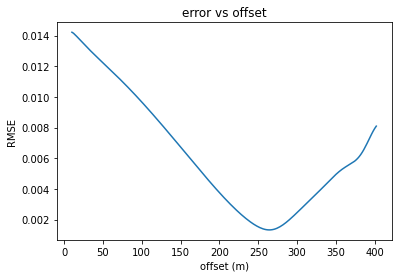

In [7]:
#plot error function offset
erroff = np.sqrt(np.sum((datafd - analytic) ** 2, axis=0)
                    / np.sum(analytic ** 2,axis=0))
plt.plot(offset, erroff)
plt.xlabel("offset (m)")
plt.ylabel("RMSE")
plt.title("error vs offset")
plt.show()

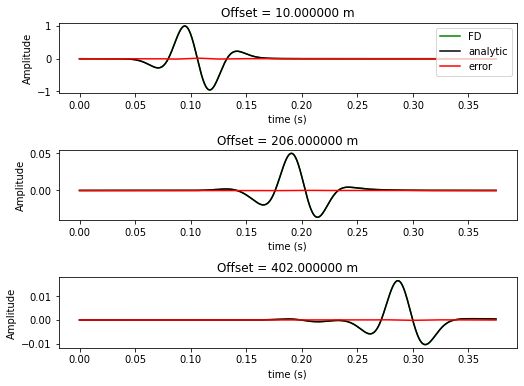

In [8]:
#plot traces short, mid and far offsets
fig, ax = plt.subplots(3, 1, figsize=[8, 6])
t = np.arange(0, datafd.shape[0]*dt, dt)

ax[0].plot(t, datafd[:,0], "g", label='FD')
ax[0].plot(t, analytic[:, 0], "k", label='analytic')
ax[0].plot(t, analytic[:, 0]-datafd[:,0], "r", label='error')
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Offset = %f m" % offset[0])
ax[0].legend(loc='upper right')

mid = int(datafd.shape[1]//2)
ax[1].plot(t, datafd[:,mid], "g")
ax[1].plot(t, analytic[:, mid], "k")
ax[1].plot(t, analytic[:, mid]-datafd[:,mid], "r")
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Offset = %f m" % offset[mid])
plt.tight_layout()

ax[2].plot(t, datafd[:,-1], "g")
ax[2].plot(t, analytic[:, -1], "k")
ax[2].plot(t, analytic[:, -1]-datafd[:,-1], "r")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("Amplitude")
ax[2].set_title("Offset = %f m" % offset[-1])
plt.tight_layout(h_pad=1, w_pad=1, pad=3)
plt.show()